In [ ]:
!pip install rarfile

In [ ]:
import os
import rarfile

def unrar(file_path, extract_path):
    try:
        # Make sure the extract directory exists or create it
        os.makedirs(extract_path, exist_ok=True)

        with rarfile.RarFile(file_path, 'r') as rar:
            rar.extractall(extract_path)

        print("Extraction successful!")
    except Exception as e:
        print(f"Error extracting: {e}")

# Example usage:
rar_file_path = '/content/bovwData.rar'
extract_to_path = '/content/ef/'

unrar(rar_file_path, extract_to_path)

Extraction successful!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


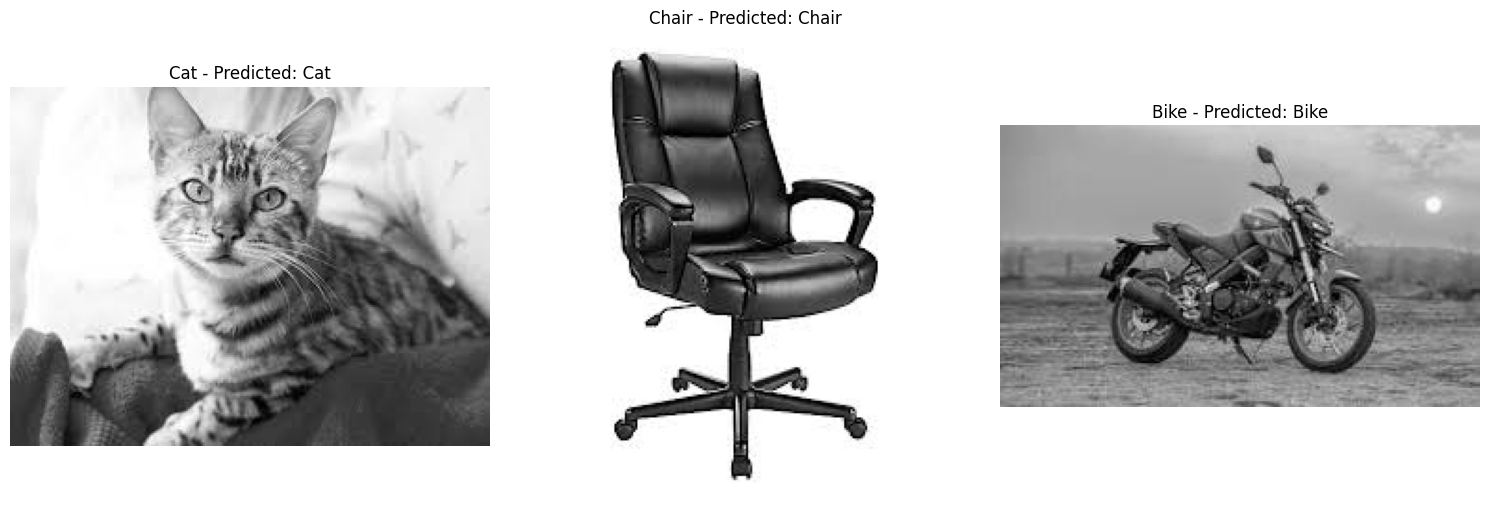

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load images
cat_images = [cv2.imread(f'/content/ef/bovwData/cat{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(1, 12)]
chair_images = [cv2.imread(f'/content/ef/bovwData/chair{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(1, 12)]
bike_images = [cv2.imread(f'/content/ef/bovwData/bike{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(1, 12)]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Extract SIFT features from training images
def extract_sift_features(images):
    descriptors = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            descriptors.extend(des)
    return np.array(descriptors)

cat_descriptors = extract_sift_features(cat_images[:10])
chair_descriptors = extract_sift_features(chair_images[:10])
bike_descriptors = extract_sift_features(bike_images[:10])

# Combine descriptors for clustering
all_descriptors = np.vstack((cat_descriptors, chair_descriptors, bike_descriptors))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=200)  # Set the number of clusters
kmeans.fit(all_descriptors)
codewords = kmeans.cluster_centers_

# Compute histograms for images
def compute_histograms(images, codewords):
    histograms = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            hist = np.zeros(len(codewords))
            labels = kmeans.predict(des)
            for label in labels:
                hist[label] += 1
            histograms.append(hist)
    return np.array(histograms)

# Compute histograms for training images
cat_hist_train = compute_histograms(cat_images[:10], codewords)
chair_hist_train = compute_histograms(chair_images[:10], codewords)
bike_hist_train = compute_histograms(bike_images[:10], codewords)

# Create training labels
cat_labels = np.zeros(len(cat_hist_train))
chair_labels = np.ones(len(chair_hist_train))
bike_labels = np.full(len(bike_hist_train), 2)  # Corrected typo, changed 'np.twos' to 'np.full'

# Combine training data and labels
X_train = np.vstack((cat_hist_train, chair_hist_train, bike_hist_train))
y_train = np.hstack((cat_labels, chair_labels, bike_labels))

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Set the number of neighbors
knn.fit(X_train, y_train)

# Compute histograms for test images
cat_hist_test = compute_histograms(cat_images[10:], codewords)
chair_hist_test = compute_histograms(chair_images[10:], codewords)
bike_hist_test = compute_histograms(bike_images[10:], codewords)

# Create test labels
cat_labels_test = np.zeros(len(cat_hist_test))
chair_labels_test = np.ones(len(chair_hist_test))
bike_labels_test = np.full(len(bike_hist_test), 2)  # Corrected typo, changed 'np.twos' to 'np.full'

# Combine test data and labels
X_test = np.vstack((cat_hist_test, chair_hist_test, bike_hist_test))
y_test = np.hstack((cat_labels_test, chair_labels_test, bike_labels_test))

# Predict using KNN classifier
y_pred = knn.predict(X_test)

# Display classification results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cat_images[10], cv2.COLOR_BGR2RGB))
plt.title(f'Cat - Predicted: {"Cat" if y_pred[0] == 0 else "Chair"}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(chair_images[10], cv2.COLOR_BGR2RGB))
plt.title(f'Chair - Predicted: {"Cat" if y_pred[1] == 0 else "Chair"}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(bike_images[10], cv2.COLOR_BGR2RGB))
plt.title(f'Bike - Predicted: {"Bike" if y_pred[2] == 0 else "Chair"}')
plt.axis('off')

plt.tight_layout()
plt.show()
